In [1]:
from bs4 import BeautifulSoup
import urllib2
import time
import re
import us

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.grid_search import GridSearchCV

import seaborn as sns
import os.path

%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

In [2]:
class IndeedJobs:
    'General indeed job scraper'
    _res_in_page=50
    job_title=""
#     class initializer
    def __init__(self, job_title, search_conditions={}):
        
        # query part of the url
        self.query = ""
        # conditions of search goes here
        search={}
        
        if search_conditions:
            search = search_conditions
        if ~('sort' in search): search['sort']='date'
        if ~('limit' in search): search['limit']=str(IndeedJobs._res_in_page)
        if ~('start' in search): search['start']=''

        search['q']=job_title.replace(" ", "+")
            
        self.query += "?q={}".format(search['q'])
        self.query += "&sort={}".format(search['sort'])
        self.query += "&limit={}".format(search['limit'])
        
        # job title - no need but nice to have!!!
        IndeedJobs.job_title = job_title
        IndeedJobs._res_in_page = int(search['limit'])
        
    # this function generates url based on page number
    def _get_url(self, page_number=0):
        return "http://www.indeed.com/jobs"+self.query+"&start={}".format(page_number*IndeedJobs._res_in_page)
    
    def _result_rows(self, soup):
        return soup.find('td', {'id': "resultsCol"}).find_all('div', {'class': "result"})
    
    def _get_title(self, result):
        if result.find_all('a', {'class': 'jobtitle'}):
            return result.find_all('a', {'class': 'jobtitle'})[0].text.lstrip().rstrip()
        if result.find_all('h2', {'class': 'jobtitle'}):
            return result.find_all('h2', {'class': 'jobtitle'})[0].text.lstrip().rstrip()
    
    def _get_company(self, result):
        return result.find('span').text.lstrip().rstrip()
    
    def _get_location(self, result):
        res = result.find('span', {'class':'location'}).text.lstrip().rstrip().split(', ')
        
        print res
        if len(res)>1:
            res[1] = res[1].split(' ')[0]
#         print res u'Field
        if (res[0]==unicode('United States') or 
            res[0]==unicode('Remote') or res[0]==unicode('Home Based') 
            or res[0]==unicode('Field')):
            return {'city':None,'state':None}
        if len(res) > 1:
            return {'city':res[0],'state':res[1]}
        else:
            return {'city':None,'state':us.states.lookup(unicode(res[0].replace(' State', ''))).abbr}
    
    def _get_date(self, result):
        return result.find('span', {'class':'date'}).text.lstrip().rstrip()
    
    def _get_summary(self, result):
        return result.find('span', {'class':'summary'}).text.lstrip().rstrip()
    
    def _get_salary(self, result):    
        salary = ""
        if result.find_all('nobr'):
            salary = result.find_all('nobr')[0].text.lstrip().rstrip()
        elif result.find_all('div', {"class":"sjcl"}):
            if result.find_all('div', {"class":"sjcl"})[0].find_all('div'):
                salary = result.find_all('div', {"class":"sjcl"})[0].find_all('div')[0].text.lstrip().rstrip()
#         salary.replace('$', '')
        if salary=='':
            return {'min':None,'max':None,'mean':None}
        # order of things is important
        salary=salary.replace('$', '').replace('-', '').replace(' an', ' ').replace(' a', ' ').replace(',', '')
        salary=str(salary).split(' ')
        sal = {}
        sal['min']=float(salary[0])
        sal['max']=float(salary[0]) if len(salary)==3 else float(salary[2])
        sal['mean']=np.mean([sal['min'],sal['max']])
        if salary[-1]=='hour':
            sal['mean']=sal['mean']*40*52
        elif salary[-1]=='day':
            sal['mean']=sal['mean']*5*52
        elif salary[-1]=='month':
            sal['mean']=sal['mean']*12
        return sal
    
    def _get_page_data(self, page_number=0):
        soup=BeautifulSoup(urllib2.urlopen(self._get_url(page_number)).read(), "lxml")
        results=[]
        for result in self._result_rows(soup):
            job={}
            job["title"]=self._get_title(result)
            job["company"]=self._get_company(result)
            job["city"]=self._get_location(result)['city']
            job["state"]=self._get_location(result)['state']
            job["date"]=self._get_date(result)
            job["summary"]=self._get_summary(result)
            salary=self._get_salary(result)
#             print salary
#             job['salary'] = salary
            job["min_salary"]=salary['min']
            job["max_salary"]=salary['max']
            job["apr_yearly"]=salary['mean']
            results.append(job)
        return results
    
    def get_df(self, pages=1):
        results=[]
        for page in range(0, pages):
            results+=self._get_page_data(page)
            time.sleep(1)
        return pd.DataFrame(results).drop_duplicates()
    
    def get_urls(self, pages=1):
        for page in range(0, pages):
            print self._get_url(page)

In [3]:
q = IndeedJobs('data science')
# print q.get_urls(3)

In [4]:
# a = q.get_df(1)
# a = a[a['apr_yearly'].notnull()]
# a

In [5]:
# test = q.get_df(1)
# test

In [6]:
fname='../assets/dataset/jobs.csv'
all_jobs = ""
if os.path.isfile(fname):
    all_jobs = pd.read_csv(fname).drop(['Unnamed: 0'], axis=1)
else:
    all_jobs = IndeedJobs('data science').get_df(500)
    all_jobs.to_csv('../assets/dataset/jobs.csv', encoding='utf-8')

In [7]:
# all_jobs

In [8]:
with_salary = all_jobs[all_jobs['apr_yearly'].notnull()]

In [9]:
# with_salary

In [10]:
import plotly.plotly as py
from plotly.graph_objs import *

In [11]:
piv = pd.pivot_table(all_jobs, index='state', 
                     values=['apr_yearly'],
                     aggfunc=[np.mean, np.max, np.min]                     
                    ).reset_index()
piv.columns = piv.columns.droplevel(1)
piv1 = piv.dropna()
piv1

,state,mean,amax,amin
0,AK,56849.000000,56849.0,56849.0
1,AL,54732.000000,91464.0,18000.0
2,AR,40966.125000,56475.5,32214.0
3,AZ,77937.750000,93475.5,62400.0
4,CA,83561.131250,250000.0,13442.0
6,CT,55400.000000,90000.0,20800.0
7,DC,43800.000000,48000.0,39600.0
9,FL,84191.333333,160000.0,32555.0
10,GA,93437.333333,100000.0,83200.0
13,IL,92603.000000,150000.0,67600.0


In [12]:
def plot_data(df, item):
    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
    return [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = df['state'],
            z = piv[item].astype(float),
            locationmode = 'USA-states',
    #         text = df['text'],
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Millions USD"
            )
        ) ]
def plot_layout(title):
    return dict(
            title = title,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)',
            ),
        )

In [13]:
fig = dict( data=plot_data(piv1, 'mean'), layout=plot_layout('Mean offered Salary') )
py.iplot( fig, filename='MeanSalary' )

In [14]:
fig = dict( data=plot_data(piv1, 'amax'), layout=plot_layout('Max offered Salary') )
py.iplot( fig, filename='MaxSalary' )

In [15]:
fig = dict( data=plot_data(piv1, 'amin'), layout=plot_layout('Min offered Salary') )
py.iplot( fig, filename='MinSalary' )

In [16]:
piv = pd.pivot_table(all_jobs.dropna(), index='company', 
                     values=['apr_yearly'],
                     aggfunc=[np.mean, np.max, np.min, np.count_nonzero]                     
                    ).reset_index()
piv.columns = piv.columns.droplevel(1)
piv.sort_values(['count_nonzero'], ascending=[False])

,company,mean,amax,amin,count_nonzero
19,Hamilton County Department of Education,12960.000,13500.0,12600.0,5.0
68,"University of California, Santa Barbara",57375.200,74268.0,47174.4,5.0
79,ZP Group,89120.000,110000.0,54080.0,4.0
4,Arkansas Department of Human Services,40966.125,56475.5,32214.0,4.0
37,North Carolina Office of State Human Resources,57063.500,89000.0,36148.5,3.0
61,"State of Oregon, Department of Administrative Serv...",70866.000,74712.0,67020.0,2.0
60,State of Ohio Jobs,46020.000,51917.0,40123.0,2.0
47,"Relevante, Inc",121000.000,137000.0,105000.0,2.0
1,AIR FORCE,66280.500,97112.0,35449.0,2.0
30,Louisville Metro Government,45864.000,45864.0,45864.0,2.0


In [17]:
piv = piv.dropna()
piv1 = piv[(piv['count_nonzero']>1.0)]
piv1

,company,mean,amax,amin,count_nonzero
1,AIR FORCE,66280.500,97112.0,35449.0,2.0
4,Arkansas Department of Human Services,40966.125,56475.5,32214.0,4.0
5,Arlington Public Schools,94987.000,99446.0,90528.0,2.0
6,Avalon Executive Search,95000.000,100000.0,90000.0,2.0
19,Hamilton County Department of Education,12960.000,13500.0,12600.0,5.0
30,Louisville Metro Government,45864.000,45864.0,45864.0,2.0
37,North Carolina Office of State Human Resources,57063.500,89000.0,36148.5,3.0
40,Oscar Technology,135000.000,160000.0,110000.0,2.0
47,"Relevante, Inc",121000.000,137000.0,105000.0,2.0
60,State of Ohio Jobs,46020.000,51917.0,40123.0,2.0


In [18]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=list(piv1.company),
    y=list(piv1['mean']),
    name='Mean'
)
trace2 = go.Bar(
    x=list(piv1.company),
    y=list(piv1.amax),
    name='Maximum',
    text=list(piv1.count_nonzero)
)
trace3 = go.Bar(
    x=list(piv1.company),
    y=list(piv1.amin),
    name='Minimum'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-salary')


In [19]:
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
# piv = pd.pivot_table(all_jobs.dropna(), index='city', 
#                      values=['apr_yearly'],
#                      aggfunc=[np.mean, np.max, np.min, np.count_nonzero]                     
#                     ).reset_index()
# piv.columns = piv.columns.droplevel(1)
# piv.columns = ['name', 'mean', 'max', 'min', 'count']
# t = piv.merge(df, on='city', how='left')
# t

In [20]:
piv = pd.pivot_table(all_jobs.dropna(), index='city', 
                     values=['apr_yearly'],
                     aggfunc=[np.mean, np.max, np.min, np.count_nonzero]                     
                    ).reset_index()
piv.columns = piv.columns.droplevel(1)
piv = piv.sort_values(['mean'], ascending=[False])
print piv.count()
piv

city             77
mean             77
amax             77
amin             77
count_nonzero    77
dtype: int64


,city,mean,amax,amin,count_nonzero
64,Santa Clara,231400.00,231400.0,231400.0,1.0
40,Los Angeles,170489.75,250000.0,90979.5,2.0
35,Jacksonville,160000.00,160000.0,160000.0,2.0
13,Chicago,150000.00,150000.0,150000.0,1.0
22,Fort Meade,137500.00,137500.0,137500.0,1.0
67,Silver Spring,125000.00,125000.0,125000.0,1.0
14,Columbia,125000.00,125000.0,125000.0,1.0
70,Tampa,120000.00,120000.0,120000.0,1.0
68,Springfield,120000.00,120000.0,120000.0,1.0
2,Ashburn,114400.00,114400.0,114400.0,1.0


In [67]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
piv['text']=piv['city']+'<br>Mean Salary '+piv['mean'].astype(str)
limits=[(100001,300000), (80001,100000), (60001,80000), (40001,60000), (10000,40000)]
colors = ["lightgrey", "rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)"]
cities = []
scale = 500
for i in range(len(limits)):
    lim = limits[i]
    piv_sub = piv[(piv['mean']>lim[0])&(piv['mean']<lim[1])]
    
#     print (lim[0], lim[1])
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
#         lon = df_sub['lon'],
#         lat = df_sub['lat'],
        text = piv_sub['text'],
        marker = dict(
#             size = df_sub['pop']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
#     print city
    cities.append(city)
layout = dict(
        title = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )
# fig = dict( data=cities, layout=layout )
# py.iplot( fig, validate=False, filename='d3-bubble-map-populations' )

In [22]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_us_cities.csv')
df.head()

,name,pop,lat,lon
0,New York,8287238,40.730599,-73.986581
1,Los Angeles,3826423,34.053717,-118.242727
2,Chicago,2705627,41.875555,-87.624421
3,Houston,2129784,29.758938,-95.367697
4,Philadelphia,1539313,39.952335,-75.163789


In [23]:
df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,3),(3,10),(10,20),(21,50),(50,3000)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
cities = []
scale = 5000

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
#     print df_sub
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['pop']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = dict(
        title = '2014 US city populations<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=cities, layout=layout )
py.iplot( fig, validate=False, filename='d3-bubble-map-populations' )


In [24]:
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=10, # Only use the top 50 most common words
)

In [25]:
summary_tokens = v.fit_transform(all_jobs.summary).todense()
summary_tokens = pd.DataFrame(summary_tokens, columns=v.get_feature_names())
summary_tokens

,bachelor,computer,data,degree,engineering,experience,field,information,related,science
0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,0
6,0,1,1,1,0,0,1,1,1,1
7,0,0,1,0,0,0,0,0,0,0
8,0,1,1,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0


In [26]:
title_tokens = v.fit_transform(all_jobs.title).todense()
title_tokens = pd.DataFrame(title_tokens, columns=v.get_feature_names())
# title_tokens

In [27]:
merged_tokens = pd.concat([summary_tokens, title_tokens], axis=1)
merged_tokens = merged_tokens.groupby(merged_tokens.columns, axis=1).sum()

In [28]:
# merged_tokens

In [77]:
# all_j = pd.get_dummies(all_jobs, columns=['state', 'company', 'city'])
all_j = pd.get_dummies(all_jobs, columns=['state'])
# all_j

In [78]:
all_j_2=pd.concat([all_j, merged_tokens], axis=1)
# all_j_2

In [79]:
all_j_2=all_j_2[all_j_2['apr_yearly'].notnull()]

In [80]:
all_j_3=all_j_2.drop(['apr_yearly', 'max_salary', 'min_salary', 'summary', 'title', 'date', 'company', 'city'], axis=1)
# all_j_3

In [81]:
is_high_paid = (all_j_2['apr_yearly']>=70000)

In [82]:
# all_j_3.isnull().count()

In [83]:
# all_j_3 = all_j_3.fillna(0)

In [84]:
y=is_high_paid
X=all_j_3

In [85]:
print y.shape, X.shape

(111,) (111, 67)


In [86]:
X

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_MI,state_MN,state_MO,state_MS,state_MT,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,analyst,bachelor,computer,data,degree,developer,engineer,engineering,experience,field,information,manager,related,science,scientist,senior,software,specialist,sr
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,0,0,0,0,1,1,0,1,1,0,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
log_model_1 = LogisticRegression(penalty='l1')
print log_model_1.fit(X,y)
print log_model_1.score(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.756756756757


In [88]:
log_model_2 = LogisticRegression(penalty='l1', C=0.1)
print log_model_2.fit(X,y)
print log_model_2.score(X,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.576576576577


In [89]:
log_model_3 = LogisticRegression(penalty='l1', C=0.08)
print log_model_3.fit(X,y)
print log_model_3.score(X,y)

LogisticRegression(C=0.08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.576576576577


In [90]:
model = LogisticRegression()
Cs = [.01, .02, .03, .04, .05, 0.07, .08, .09, .1, .5, 1]
Ls = ['l1', 'l2']
grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
#                     verbose=10,
                    cv = 6
                   )

In [91]:
grid

GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [92]:
grid.fit(X,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.08, 0.09, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [93]:
grid.best_score_

0.60360360360360366

In [94]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [95]:
from sklearn.metrics import confusion_matrix, classification_report

In [96]:
predictions = grid.best_estimator_.predict(X)

In [97]:
confusion_matrix(y, predictions)

array([[61,  3],
       [25, 22]])

In [98]:
print classification_report(y, predictions)

             precision    recall  f1-score   support

      False       0.71      0.95      0.81        64
       True       0.88      0.47      0.61        47

avg / total       0.78      0.75      0.73       111



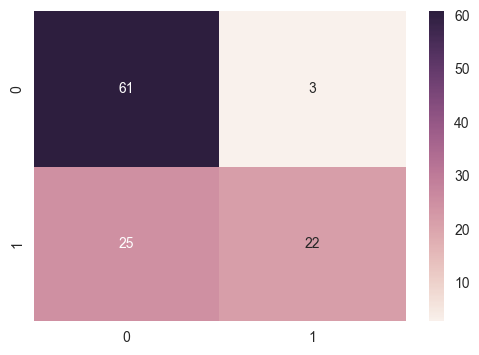

In [99]:
sns.heatmap(confusion_matrix(y, predictions), annot=True)

In [100]:
from sklearn.cross_validation import train_test_split

In [101]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [102]:
logistic_reg = grid.best_estimator_

In [103]:
model_1 = logistic_reg.fit(x_train, y_train)

In [104]:
model_1.score(x_train, y_train)

0.77108433734939763

In [105]:
model_1.score(x_test, y_test)

0.5

# Train test splits

In [57]:
from sklearn.cross_validation import train_test_split

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, y)
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape

(83, 68) (83,)
(28, 68) (28,)


In [59]:
# Now er model like before
logistic_reg = LogisticRegression()
model = LogisticRegression()
Cs = [.01, .02, .03, .04, .05, 0.07, .08, .09, .1, .5, 1]
Ls = ['l1', 'l2']
grid = GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
#                     verbose=10,
                    cv = 6
                   )

In [68]:
grid.fit(x_train,y_train)
print grid.best_estimator_
print grid.best_score_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
1.0


In [69]:
grid.fit(x_test,y_test)
print grid.best_estimator_
print grid.best_score_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.964285714286


In [70]:
grid.fit(X,y)
print grid.best_estimator_
print grid.best_score_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.981981981982


In [64]:
# # we fit our x and y but we fit our training data to model

# model_1 = logistic_reg.fit(x_train, y_train)

# #we can check the score on that trainnkg dey
# model_1.score(x_train, y_train)

In [65]:
# # but we want to seee how it handles new data, like the test
# model_1.score(x_test, y_test)

In [66]:
#If score is not high we are successfull

In [75]:
all_j_2=pd.concat([all_j, summary_tokens], axis=1)
all_j_2=all_j_2[all_j_2['apr_yearly'].notnull()]
all_j_2=all_j_2.drop(['max_salary', 'min_salary', 'summary', 'title', 'date', 'company', 'city'], axis=1)
all_j_2

,apr_yearly,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_MI,state_MN,state_MO,state_MS,...,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,bachelor,computer,data,degree,engineering,experience,field,information,related,science
3,49545.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0
6,34279.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0,0,1,1,1,1
8,69612.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0
10,56108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0
14,46042.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,1,0,0,0,0,1,0
15,36148.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1
16,87126.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0
17,40123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,1
24,71722.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1
28,71427.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0
